# Initialization

In [1]:
!nvidia-smi

Sat Jul  4 14:34:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      6%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import math, re, os, random
import os
from tqdm import tqdm
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import pathlib
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import load_model
import math
from sklearn.model_selection import KFold, StratifiedKFold

print("TF version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

TF version 2.2.0


In [3]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
#!mkdir -p ~/.kaggle && cp '/content/drive/My Drive/kaggle.json' ~/.kaggle/ && chmod 600 ~/.kaggle/

In [6]:
#!kaggle datasets download -d mylee2009/shopee-round-2-product-detection-challenge

In [7]:
#!unzip -q shopee-round-2-product-detection-challenge.zip -d dataset

In [8]:
#!rm shopee-round-2-product-detection-challenge.zip

In [9]:
#!cp -R '/content/drive/Shared drives/Jogjas Island [Shopee CL]/Week2/Pretrained' weight

# Inference

In [10]:
MODEL_NAME = "EfficientNet-B4(380)_reget_trainable_1fold_V4"
IMG_HEIGHT = 380
IMG_WIDTH = 380
IMAGE_SIZE = (IMG_HEIGHT, IMG_WIDTH)
EPOCHS = 6
BATCH_SIZE = 40 * strategy.num_replicas_in_sync
SEED = 177013
SKIP_VALIDATION = False
SKIP_TRAINING = True
TTA_NUM = 1
ES_PATIENCE = 10
RLROP_PATIENCE = 10
DECAY_RATE = 0.5
DROPOUT_RATE = 0.2


random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [11]:
BASE_DIR = "../input/shopee-product-detection-student/" 
TRAIN_DIR = pathlib.Path(BASE_DIR + "train/train/train")
TEST_DIR = pathlib.Path(BASE_DIR + "test/test/test/")

CLASS_NAMES = np.sort(np.array([item.name for item in TRAIN_DIR.glob('*')]))
#list_ds = tf.data.Dataset.list_files(str(TRAIN_DIR/'*/*'))
#IMAGE_COUNT = len(list(TRAIN_DIR.glob('*/*.jpg')))

In [12]:
CLASSES = ['short dress',
  'long dress',
  'women top',
  'women outerwear',
  'women pants',
  'ring',
  'earring',
  'hat',
  'purse',
  'bag / case',
  'casing HP',
  'iphone ',
  'clock',
  'baby gear',
  'rice cooker',
  'coffee',
  'women flatshoes',
  'heels',
  'household electronic',
  'storage device',
  'berdoom furniture',
  'tennis/badminton equipment',
  'bicycle equipment',
  'handwear / footwear',
  'watches',
  'belt ',
  'audio equipment',
  'toy vehicle',
  'man outerwear',
  'man pants',
  'man shoes',
  'snack',
  'PPE',
  'antiseptic',
  'skincare / cosmetic',
  'perfume',
  'hygiene equipment',
  'laptop & accessories',
  'tableware',
  'vase',
  'bathroom equipment',
  'living room furniture']

In [13]:
testdf = pd.read_csv(BASE_DIR+"test.csv",dtype=str)
testdf.head()

,filename,category
0,fd663cf2b6e1d7b02938c6aaae0a32d2.jpg,43
1,c7fd77508a8c355eaab0d4e10efd6b15.jpg,43
2,127f3e6d6e3491b2459812353f33a913.jpg,43
3,5ca4f2da11eda083064e6c36f37eeb81.jpg,43
4,46d681a542f2c71be017eef6aae23313.jpg,43


In [14]:
'''
traindir_df = pd.read_csv("/content/drive/Shared drives/Jogjas Island [Shopee CL]/Week2/Training/train_with_dir.csv",dtype=str)
traindir_df = traindir_df.sample(frac=1.0).reset_index(drop=True)
traindir_df.head()

Y_train = traindir_df[["category"]]

skf = StratifiedKFold(n_splits = 5, random_state = SEED, shuffle = True)
#finetunedf.describe()
'''

'\ntraindir_df = pd.read_csv("/content/drive/Shared drives/Jogjas Island [Shopee CL]/Week2/Training/train_with_dir.csv",dtype=str)\ntraindir_df = traindir_df.sample(frac=1.0).reset_index(drop=True)\ntraindir_df.head()\n\nY_train = traindir_df[["category"]]\n\nskf = StratifiedKFold(n_splits = 5, random_state = SEED, shuffle = True)\n#finetunedf.describe()\n'

In [15]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

'''
                                                                    rotation_range=40,
                                                                    width_shift_range=0.2,
                                                                    height_shift_range=0.2,
                                                                    shear_range=0.2,
                                                                    zoom_range=0.2,
                                                                    horizontal_flip=True,
                                                                    fill_mode="nearest",
'''
train_ds = train_generator.flow_from_directory(directory=str(TRAIN_DIR),
                                                batch_size=BATCH_SIZE,
                                                shuffle=True,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                classes = list(CLASS_NAMES),
                                                seed = SEED)
                                                #subset='training')
'''
validation_ds = train_generator.flow_from_directory(directory=str(TRAIN_DIR),
                                                batch_size=BATCH_SIZE,
                                                shuffle=True,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                classes = list(CLASS_NAMES),
                                                seed = SEED,
                                                subset='validation')

VAL_SPLIT = 0.19
train_take = np.ceil(VAL_SPLIT * IMAGE_COUNT)

validation_ds = train_ds.skip(train_take)
train_ds = train_ds.take(train_take)

STEPS_PER_EPOCH = train_take // BATCH_SIZE
VAL_STEPS_PER_EPOCH = (IMAGE_COUNT-train_take) // BATCH_SIZE
'''

STEPS_PER_EPOCH = train_ds.samples // BATCH_SIZE
#VAL_STEPS_PER_EPOCH = validation_ds.samples // BATCH_SIZE

Found 105390 images belonging to 42 classes.


In [16]:
def get_training_dataset():
  return train_ds
def get_validation_dataset():
  return validation_ds
def get_test_dataset():
  return test_ds  

In [17]:
def get_callback():
  filepath = "../input/output/"+MODEL_NAME+"-{epoch:02d}.hdf5"
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

  es = EarlyStopping(monitor = 'loss', mode = 'min', patience = ES_PATIENCE, restore_best_weights = True, verbose = 1)
  rlrop = ReduceLROnPlateau(monitor = 'loss', mode = 'min', patience = RLROP_PATIENCE, 
                          factor = DECAY_RATE, min_lr = 1e-6, verbose = 1)
  return [model_checkpoint_callback, rlrop]

In [18]:
!pip install -q efficientnet
import efficientnet.tfkeras as efn

In [19]:
if not SKIP_TRAINING:
  history = model.fit(train_ds, 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    epochs=EPOCHS, 
                    #validation_data = validation_ds,
                    #validation_steps = VAL_STEPS_PER_EPOCH,
                    verbose=1,
                    max_queue_size = 80,
                    workers = 128,
                    callbacks = get_callback())
  model.save("../input/output/{0}-Final.hdf5".format(MODEL_NAME))

In [20]:
class_names = sorted(train_ds.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
print(class_names)
for image_batch, label_batch in train_ds:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

['00' '01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11' '12' '13'
 '14' '15' '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27'
 '28' '29' '30' '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41']
Image batch shape:  (40, 380, 380, 3)
Label batch shape:  (40, 42)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Model)      (None, 16, 16, 1792)      17673816  
_________________________________________________________________
gap (GlobalAveragePooling2D) (None, 1792)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 1792)              0         
_________________________________________________________________
fc_out (Dense)               (None, 42)                75306     
Total params: 17,749,122
Trainable params: 4,662,938
Non-trainable params: 13,086,184
_________________________________________________________________
Found 12186 validated image filenames.
Image batch shape:  (32, 380, 380, 3)
2/2 [==============================] - 0s 175ms/step


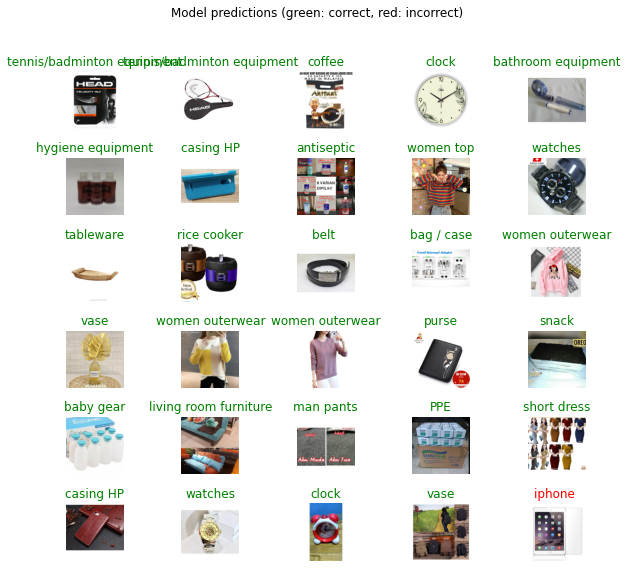

In [21]:
preds = []

IMG_SIZE_1 = (380, 380)
MODEL_NAME_1 = "EfficientNet-B4(380)"
model1 = tf.keras.models.load_model("../input/pretrainedweight/EfficientNet-B4(380)_reget_trainable_1fold_V4-02.hdf5")
model1.summary()

test_ds1 = test_generator.flow_from_dataframe(dataframe = testdf,
                                              directory=str(TEST_DIR),
                                              x_col="filename",
                                              y_col=None,
                                              shuffle=False,
                                              class_mode=None,
                                              seed = SEED,
                                              target_size=IMG_SIZE_1)

for image_test in test_ds1:
  print("Image batch shape: ", image_test.shape)
  break
    
test_ds1.reset()
predicted_test1 = model1.predict(test_ds1, 
                                  verbose=1,
                                  max_queue_size=72,
                                  workers=128)
preds.append(predicted_test1)

predicted_batch = model1.predict(image_batch, 
                                 verbose=1,
                                 max_queue_size=72,
                                 workers=128)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

label_id = np.argmax(label_batch, axis=-1)
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(CLASSES[predicted_label_batch[n].astype(int)], color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Model)      (None, 16, 16, 2048)      28513520  
_________________________________________________________________
gap (GlobalAveragePooling2D) (None, 2048)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 2048)              0         
_________________________________________________________________
fc_out (Dense)               (None, 42)                86058     
Total params: 28,599,578
Trainable params: 10,026,282
Non-trainable params: 18,573,296
_________________________________________________________________
Found 12186 validated image filenames.
Image batch shape:  (32, 456, 456, 3)
2/2 [==============================] - 0s 173ms/step


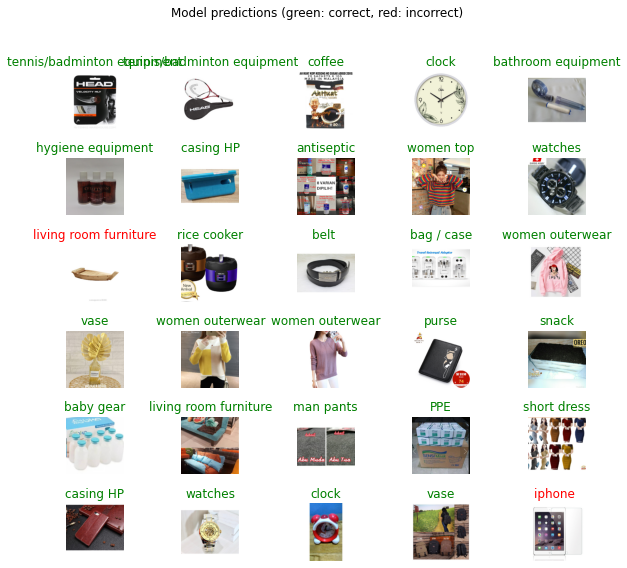

In [22]:
IMG_SIZE_2 = (456, 456)
MODEL_NAME_2 = "EfficientNet-B5(456)"
model2 = tf.keras.models.load_model("../input/pretrainedweight/EfficientNetB5-Final-Unfrozen-V6.hdf5")
model2.summary()

test_ds2 = test_generator.flow_from_dataframe(dataframe = testdf,
                                              directory=str(TEST_DIR),
                                              x_col="filename",
                                              y_col=None,
                                              shuffle=False,
                                              class_mode=None,
                                              seed = SEED,
                                              target_size=IMG_SIZE_2)

for image_test in test_ds2:
  print("Image batch shape: ", image_test.shape)
  break
    
test_ds2.reset()
predicted_test2 = model2.predict(test_ds2, 
                                  verbose=1,
                                  max_queue_size=72,
                                  workers=128)
preds.append(predicted_test2)

predicted_batch = model2.predict(image_batch, 
                                 verbose=1,
                                 max_queue_size=72,
                                 workers=128)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

label_id = np.argmax(label_batch, axis=-1)
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(CLASSES[predicted_label_batch[n].astype(int)], color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 16, 16, 2048)      20861480  
_________________________________________________________________
gap (GlobalAveragePooling2D) (None, 2048)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 2048)              0         
_________________________________________________________________
fc_out (Dense)               (None, 42)                86058     
Total params: 20,947,538
Trainable params: 13,330,346
Non-trainable params: 7,617,192
_________________________________________________________________
Image batch shape:  (32, 380, 380, 3)
2/2 [==============================] - 0s 120ms/step


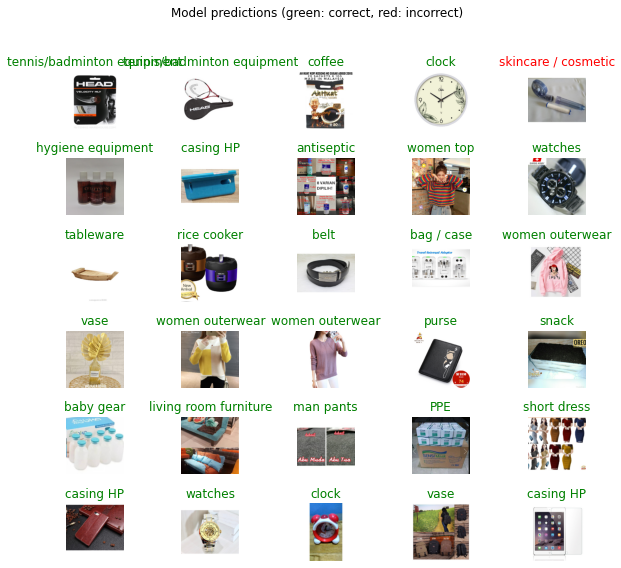

In [23]:
IMG_SIZE_3 = (380, 380)
MODEL_NAME_3 = "Xception(380)"
model3 = tf.keras.models.load_model("../input/pretrainedweight/Xception_unfrozen(380)-04-Best.hdf5")
model3.summary()

'''
test_ds3 = test_generator.flow_from_dataframe(dataframe = testdf,
                                              directory=str(TEST_DIR),
                                              x_col="filename",
                                              y_col=None,
                                              shuffle=False,
                                              class_mode=None,
                                              seed = SEED,
                                              target_size=IMG_SIZE_3)
'''

for image_test in test_ds1:
  print("Image batch shape: ", image_test.shape)
  break
    
test_ds1.reset()
predicted_test3 = model3.predict(test_ds1, 
                                  verbose=1,
                                  max_queue_size=72,
                                  workers=128)
preds.append(predicted_test3)

predicted_batch = model3.predict(image_batch, 
                                 verbose=1,
                                 max_queue_size=72,
                                 workers=128)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

label_id = np.argmax(label_batch, axis=-1)
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(CLASSES[predicted_label_batch[n].astype(int)], color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [24]:
final_pred = np.mean(preds, axis=0)
predicted_test_id = np.argmax(final_pred, axis=-1)
predicted_test_id1 = np.argmax(preds[0], axis=-1)
predicted_test_id2 = np.argmax(preds[1], axis=-1)
predicted_test_id3 = np.argmax(preds[2], axis=-1)
predicted_label_test = class_names[predicted_test_id]

In [25]:
print(final_pred)
print(preds[0])
print(preds[1])
print(preds[2])

[[0.00041599 0.01823375 0.0022995  ... 0.00292462 0.00477791 0.20588577]
 [0.00110579 0.00101218 0.00087221 ... 0.00176284 0.00081924 0.00131486]
 [0.00439573 0.00150753 0.00436697 ... 0.00113324 0.00242553 0.00292129]
 ...
 [0.00049215 0.00384962 0.00150303 ... 0.00999821 0.00738861 0.00232596]
 [0.00078738 0.00037561 0.00063382 ... 0.00055625 0.0003917  0.00108648]
 [0.00129375 0.00082341 0.00052871 ... 0.00048487 0.00142099 0.00082659]]
[[2.5194595e-04 1.2126911e-03 1.7973375e-04 ... 6.6145956e-05
  1.1323970e-03 1.1300106e-01]
 [1.1369647e-06 5.0771979e-07 1.1651948e-05 ... 8.9022069e-07
  5.9315485e-06 7.6135357e-06]
 [1.8068777e-03 2.0756395e-04 1.3699823e-03 ... 7.0237831e-05
  5.2096071e-05 5.0065715e-05]
 ...
 [5.5200636e-04 1.4264758e-03 3.0859828e-03 ... 2.0693177e-02
  2.4966358e-03 5.1701167e-03]
 [7.9394545e-07 6.7039826e-07 4.3664812e-07 ... 5.8066212e-06
  9.7107959e-06 8.3980995e-05]
 [6.0973348e-06 5.4964867e-06 8.8996232e-05 ... 1.0526935e-05
  1.8563308e-04 9.821880

In [26]:
labels = (train_ds.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_test_id]
predictions1 = [labels[k] for k in predicted_test_id1]
predictions2 = [labels[k] for k in predicted_test_id2]
predictions3 = [labels[k] for k in predicted_test_id3]

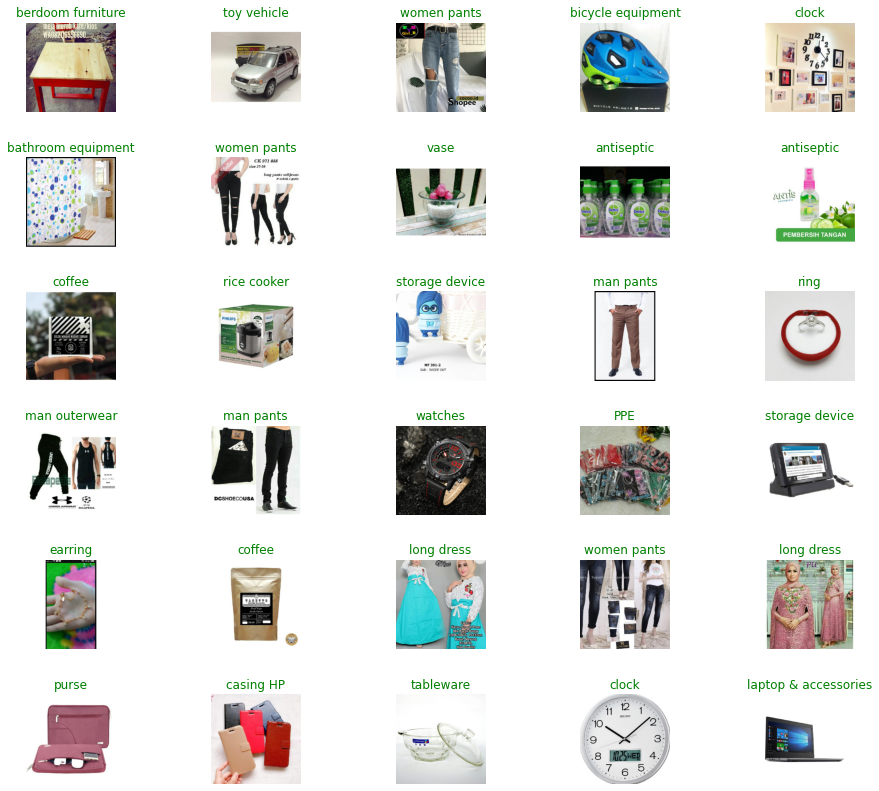

In [27]:
plt.figure(figsize=(16,14))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_test[n])
  color = "green"
  plt.title(CLASSES[predictions[n].astype(int)], color=color)
  plt.axis('off')

# Create Submission

In [29]:
test_ds1.reset()
filename = test_ds1.filenames

results0 = pd.DataFrame({"filename":filename,
                      "category":predictions})
results0.to_csv("results_{0}_{1}_{2}.csv".format(MODEL_NAME_1,MODEL_NAME_2,MODEL_NAME_3),index=False)

In [28]:
results1 = pd.DataFrame({"filename":filename,
                      "category":predictions1})
results1.to_csv("results_{0}.csv".format(MODEL_NAME_1),index=False)

results2 = pd.DataFrame({"filename":filename,
                      "category":predictions2})
results2.to_csv("results_{0}.csv".format(MODEL_NAME_2),index=False)

results3 = pd.DataFrame({"filename":filename,
                      "category":predictions3})
results3.to_csv("results_{0}.csv".format(MODEL_NAME_3),index=False)